In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim

In [2]:
# generate reference trajectory
dt = 0.01
xa1 = np.zeros((mf.STATE_LEN, 1)); xa1[:6] = np.array([[-1.57],[0],[-7],[12],[0],[0]])
xb1 = np.zeros((mf.STATE_LEN, 1)); xb1[:6] = np.array([[0],[0],[-7],[-10],[0],[0]])
xc1 = np.zeros((mf.STATE_LEN, 1)); xc1[:6] = np.array([[0],[0],[10],[-10],[0],[0]])

posa, y_IMUa = traj.gen_poly_traj(xa1, xb1, t0=0, tf=10, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb1, xc1, t0=0, tf=10, dt=dt)
pos1 = np.append(posa, posb, axis=1)
y_IMU1 = np.append(y_IMUa, y_IMUb, axis=1)

xa2 = np.zeros((mf.STATE_LEN, 1)); xa2[:6] = np.array([[1.57],[0],[-5],[-12],[0],[1]])
xb2 = np.zeros((mf.STATE_LEN, 1)); xb2[:6] = np.array([[0],[0],[5],[-5],[1],[0]])
xc2 = np.zeros((mf.STATE_LEN, 1)); xc2[:6] = np.array([[1.57],[0],[12],[10],[0],[1]])

posa, y_IMUa = traj.gen_poly_traj(xa2, xb2, t0=0, tf=10, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb2, xc2, t0=0, tf=10, dt=dt)
pos2 = np.append(posa, posb, axis=1)
y_IMU2 = np.append(y_IMUa, y_IMUb, axis=1)

xa3 = np.zeros((mf.STATE_LEN, 1)); xa3[:6] = np.array([[0],[0],[7],[5],[0],[-1]])
xb3 = np.zeros((mf.STATE_LEN, 1)); xb3[:6] = np.array([[3.14],[0],[-10],[5],[0],[1]])

posa, y_IMUa = traj.gen_poly_traj(xa3, xb3, t0=0, tf=10, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb3, xa3, t0=0, tf=10, dt=dt)
pos3 = np.append(posa, posb, axis=1)
y_IMU3 = np.append(y_IMUa, y_IMUb, axis=1)

pos_len = pos1.shape[1] # Assumes that all paths have the same length

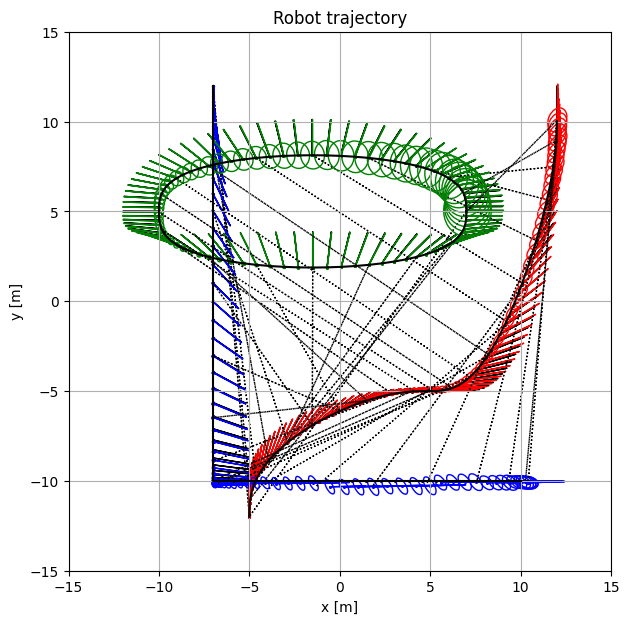

In [3]:
# Generate noise
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets

y_IMU1 = traj.gen_noise(y_IMU1, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))
y_IMU2 = traj.gen_noise(y_IMU2, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))
y_IMU3 = traj.gen_noise(y_IMU3, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.00],[0.0],[0.0]]))

# Setup robots and anchors:
robot1 = sim.Robot_single(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R)
robot2 = sim.Robot_single(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R)
robot3 = sim.Robot_single(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R)

# Setup innovation:
inno_log = np.zeros((3,pos_len))
inno_pos = np.zeros((2, 0))

# Setup plot:
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::25], color='black')
rp.plot_position(ax, pos2[:,::25], color='black')
rp.plot_position(ax, pos3[:,::25], color='black')

robot1.draw_position(ax, color='blue')
robot2.draw_position(ax, color='red')
robot3.draw_position(ax, color='green')

# Run the algorithm
for i in range(pos_len-1):
    robot1.predict()
    robot2.predict()
    robot3.predict()
    if (i % 25 == 0):
        robot1.draw_position(ax, color='blue')
        robot2.draw_position(ax, color='red')
        robot3.draw_position(ax, color='green')
    if (i % 100 == 0):
        robot2.robot_meas(robot3, ax, sr=R_r, sb=R_b)
        robot1.robot_meas(robot2, ax, sr=R_r, sb=R_b)